# Data Analysis

In [1]:
import os
import sys
import findspark # We use this function to find PySpark in venv

In [2]:
# --- ENVIRONMENT CONFIGURATION ---
# Initialize findspark to automatically locate the Spark installation in the virtual env.
# This sets SPARK_HOME and PYTHONPATH variables dynamically.
findspark.init()

# Set JAVA_HOME explicitly to the default Ubuntu OpenJDK path.
# This bridges the gap between Python and the JVM.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/default-java"

from pyspark.sql import SparkSession
from pyspark.sql.functions import desc, hour, col # We need to import this fuctions AFTER findspark.init()

# --- INITIALIZE SPARK SESSION ---
print(" Starting Spark Engine with local JDBC driver...")

# Absolute path to the PostgreSQL JDBC driver (.jar)
# Ensure 'postgresql-42.6.0.jar' is present in the current directory.
jar_path = os.path.abspath("postgresql-42.6.0.jar")

# Build the SparkSession.
# We include the JDBC driver in the classpath to allow database connectivity.
spark = SparkSession.builder \
    .appName("BankFraudAnalysis") \
    .config("spark.jars", jar_path) \
    .config("spark.driver.extraClassPath", jar_path) \
    .getOrCreate()

print(f"Spark Engine INITIALIZED! Version: {spark.version}")

 Starting Spark Engine with local JDBC driver...


26/01/06 15:20:54 WARN Utils: Your hostname, bruce-Latitude-3420 resolves to a loopback address: 127.0.1.1; using 192.168.1.2 instead (on interface wlp0s20f3)
26/01/06 15:20:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
26/01/06 15:20:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Spark Engine INITIALIZED! Version: 3.5.7


In [3]:
# --- DATABASE CONNECTION ---
print(" Connecting to PostgreSQL database...")

# JDBC Connection String
# We connect to localhost:5434 (The Docker port exposed to the host)
jdbc_url = "jdbc:postgresql://localhost:5434/bank_fraud_db"

connection_properties = {
    "user": "admin",
    "password": "admin_password",
    "driver": "org.postgresql.Driver"
}

 Connecting to PostgreSQL database...


In [4]:
# --- DATA INGESTION (READ) ---
# Read the 'transactions' table into a Spark DataFrame
df_spark = spark.read.jdbc(
    url=jdbc_url, 
    table="transactions", 
    properties=connection_properties
)

# --- EXPLORATORY DATA ANALYSIS (EDA) ---
record_count = df_spark.count()
print(f" Total Transactions Loaded: {record_count}")

print("\n === Top 5 Highest Value Transactions ===")
df_spark.orderBy(desc("amount")).show(5)

print("\n=== Schema Inference ===")
df_spark.printSchema()

 Total Transactions Loaded: 3500

 === Top 5 Highest Value Transactions ===
+--------------------+---------+-------------------+--------+---------------+-----------+--------+
|      transaction_id|client_id|   transaction_date|  amount|       merchant|   location|is_fraud|
+--------------------+---------+-------------------+--------+---------------+-----------+--------+
|60573786-78b2-49d...|     6227|2026-01-06 05:56:01|19750.68|   Gonzalez Inc|     Gambia|    true|
|b203321f-f70c-447...|     4672|2026-01-06 05:12:00|19525.49|      Smith-Kim|     Poland|    true|
|362772bf-7665-404...|     8772|2026-01-06 05:44:01|19491.27|Martinez-Bowers|   Botswana|    true|
|49831ac5-0258-4e7...|     7265|2026-01-06 06:24:00|19476.14|      Owens-Lee|Isle of Man|    true|
|537a2efd-e15b-47c...|     4647|2026-01-06 05:40:01|19442.86|   Juarez Group|  Guatemala|    true|
+--------------------+---------+-------------------+--------+---------------+-----------+--------+
only showing top 5 rows


=== Sch

In [5]:
# --- Visual Setup ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set visual style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

 Calculating class distribution...


/tmp/ipykernel_12474/4022186896.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="is_fraud", y="count", data=class_dist, palette=["#2ecc71", "#e74c3c"])


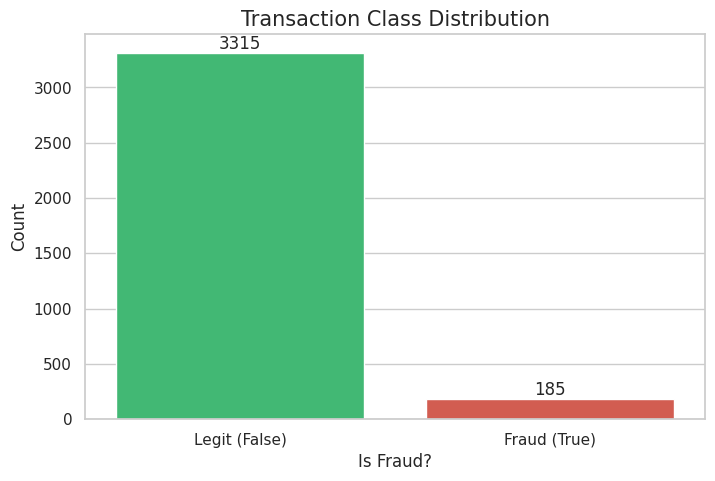

 Fraud Rate: 5.29%


In [6]:
# --- Analysis 1 - Imbalance Check ---
# Goal: Verify the Fraud vs Legit ratio (Target: ~5% Fraud)

print(" Calculating class distribution...")
class_dist = df_spark.groupBy("is_fraud").count().toPandas() # Aggregating in Spark to minimize data transfer


plt.figure(figsize=(8, 5))
ax = sns.barplot(x="is_fraud", y="count", data=class_dist, palette=["#2ecc71", "#e74c3c"])
plt.title("Transaction Class Distribution", fontsize=15)
plt.ylabel("Count")
plt.xlabel("Is Fraud?")
plt.xticks([0, 1], ['Legit (False)', 'Fraud (True)'])

# Labels
for i in ax.containers:
    ax.bar_label(i,)

plt.show()

# Calculate exact percentage
total = class_dist['count'].sum()
fraud = class_dist[class_dist['is_fraud'] == True]['count'].sum()
print(f" Fraud Rate: {(fraud/total)*100:.2f}%")

 Fetching amount data...


/tmp/ipykernel_12474/3484701851.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="is_fraud", y="amount", data=df_viz, palette=["#2ecc71", "#e74c3c"])


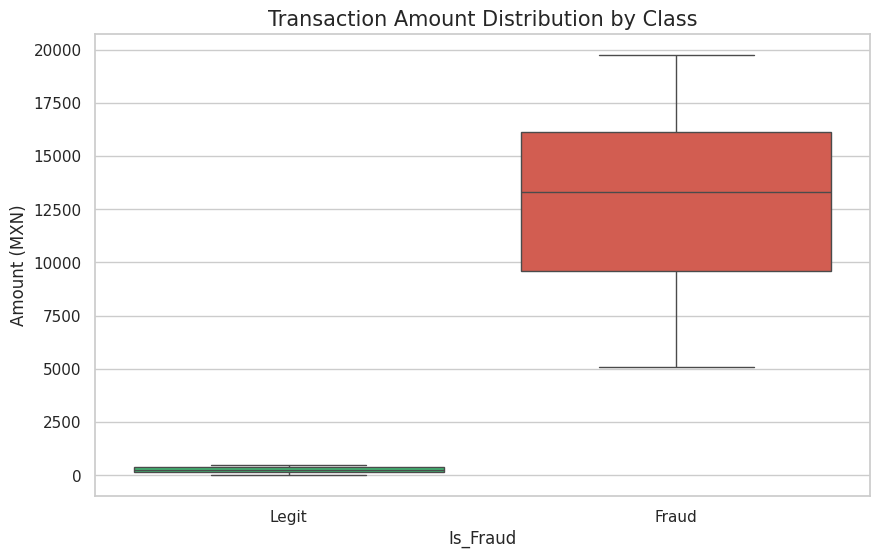

In [8]:
# --- Analysis 2 - Amount Patterns ---
# Goal: See if frauds involve higher amounts
print(" Fetching amount data...")


df_viz = df_spark.select("amount", "is_fraud").toPandas() # Fetch only necessary columns for plotting

plt.figure(figsize=(10, 6))
sns.boxplot(x="is_fraud", y="amount", data=df_viz, palette=["#2ecc71", "#e74c3c"])
plt.title("Transaction Amount Distribution by Class", fontsize=15)
plt.xlabel("Is_Fraud")
plt.ylabel(r"Amount (MXN)")
plt.xticks([0, 1], ['Legit', 'Fraud'])
plt.show()

 Analyzing temporal patterns...


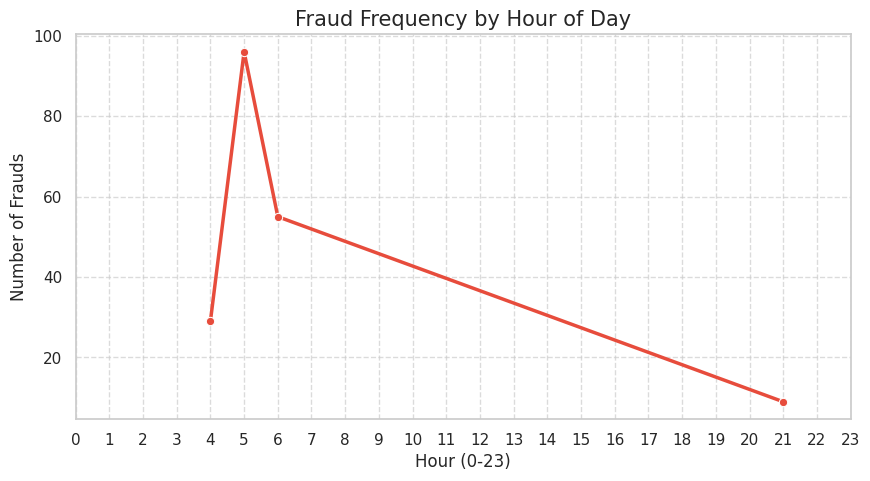

In [10]:
# --- ANALYSIS 3: Temporal Patterns (Time of Day) ---
# Goal: Identify if frauds cluster around specific hours (e.g., late night).

print(" Analyzing temporal patterns...")

# Extract Hour from Timestamp
df_time = df_spark.withColumn("hour", hour("transaction_date")) # We create a new temporary column 'hour'

# Filter ONLY Frauds and group by Hour
hourly_fraud = df_time.filter(col("is_fraud") == True) \
                      .groupBy("hour") \
                      .count() \
                      .orderBy("hour") \
                      .toPandas()

# Visualization
plt.figure(figsize=(10, 5))
sns.lineplot(x="hour", y="count", data=hourly_fraud, marker="o", color="#e74c3c", linewidth=2.5)

plt.title("Fraud Frequency by Hour of Day", fontsize=15)
plt.xlabel("Hour (0-23)", fontsize=12)
plt.ylabel("Number of Frauds", fontsize=12)
plt.xticks(range(0, 24)) # Show all hours on axis
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

 Analyzing geographical distribution...


/tmp/ipykernel_12474/2494766373.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="location", data=geo_fraud, palette="Reds_r")


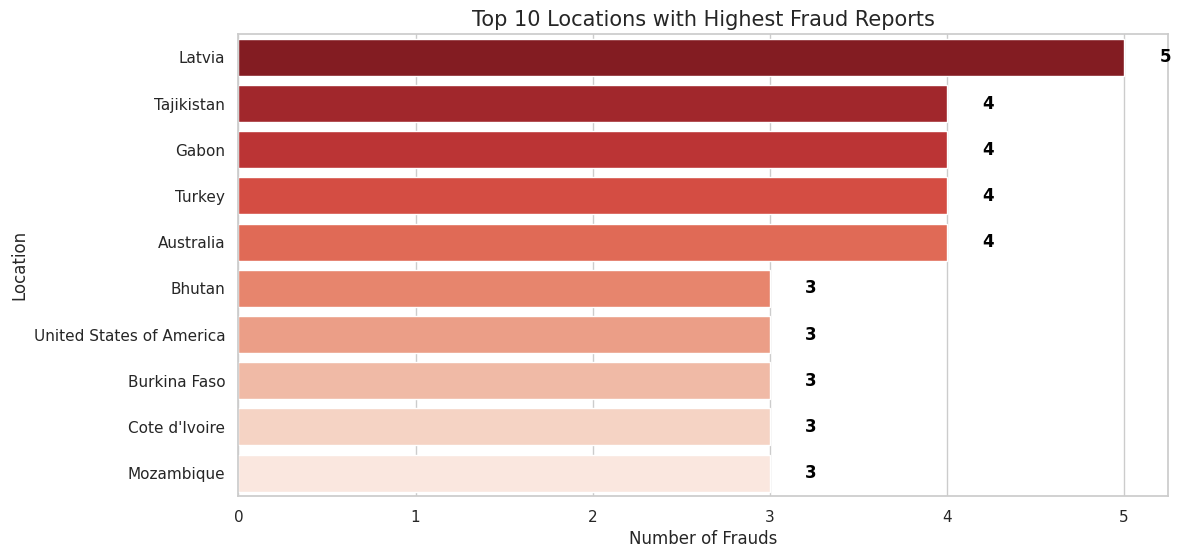

In [11]:
# --- ANALYSIS 4: Geographical Hotspots ---
# Goal: Identify top locations for fraudulent activity.

print(" Analyzing geographical distribution...")

# Group by Location, Filter for Frauds, and Count
geo_fraud = df_spark.filter(col("is_fraud") == True) \
                    .groupBy("location") \
                    .count() \
                    .orderBy(desc("count")) \
                    .limit(10) \
                    .toPandas()

# Visualization 
plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="location", data=geo_fraud, palette="Reds_r")

plt.title("Top 10 Locations with Highest Fraud Reports", fontsize=15)
plt.xlabel("Number of Frauds", fontsize=12)
plt.ylabel("Location", fontsize=12)

# Labels
for i, v in enumerate(geo_fraud['count']):
    plt.text(v + 0.2, i, str(v), color='black', va='center', fontweight='bold')

plt.show()

# ML Model

In [12]:
# ==========================================
# MACHINE LEARNING PIPELINE
# ==========================================

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [16]:
print("Starting Machine Learning Pipeline...")

# 1. FEATURE ENGINEERING 🛠️
# ------------------------------------------
# Prepare data: Extract hour and select useful columns.
# We ignore 'Location' for now due to high cardinality/noise

df_ml = df_spark.withColumn("hour", hour("transaction_date")) \
                .withColumn("is_fraud", col("is_fraud").cast("integer"))   # Cast 'is_fraud' from Boolean to Integer (True=1, False=0) required for the model

assembler = VectorAssembler(
    inputCols=["amount", "hour"],
    outputCol="features"
)

data_final = assembler.transform(df_ml).select("features", "is_fraud")

Starting Machine Learning Pipeline...


In [17]:
# TRAIN/TEST SPLIT
# ------------------------------------------
# 80% for training the model, 20% for final evaluation
train_data, test_data = data_final.randomSplit([0.8, 0.2], seed=42)

print(f" TRAINING Data: {train_data.count()} rows")
print(f" TESTING Data:  {test_data.count()} rows")

 TRAINING Data: 3801 rows
 TESTING Data:  899 rows


In [18]:
#  MODEL TRAINING (Random Forest) 
# ------------------------------------------
# Random Forest is chosen for its robustness and ability to handle non-linear boundaries
rf = RandomForestClassifier(
    labelCol="is_fraud", 
    featuresCol="features", 
    numTrees=20  # Number of trees in the forest
)

print("\n Training Model... (This might take a moment)")
model = rf.fit(train_data)
print(" Model Trained Successfully!")


 Training Model... (This might take a moment)
 Model Trained Successfully!


In [19]:
# PREDICTION & EVALUATION 
# ------------------------------------------
# Make predictions on the test set
predictions = model.transform(test_data)

# Evaluate Accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="is_fraud", 
    predictionCol="prediction", 
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)

print("="*40)
print(f"🏆 MODEL ACCURACY: {accuracy*100:.2f}%")
print("="*40)

# Display Confusion Matrix (Actual vs Predicted)
print("\n🔍 Confusion Matrix (Real vs Prediction):")

# Group by actual Class (is_fraud) and Predicted Class (prediction) to see hits and misses
predictions.groupBy("is_fraud", "prediction").count().show()

🏆 MODEL ACCURACY: 99.00%

🔍 Confusion Matrix (Real vs Prediction):
+--------+----------+-----+
|is_fraud|prediction|count|
+--------+----------+-----+
|       0|       0.0|  837|
|       1|       1.0|   53|
|       0|       1.0|    9|
+--------+----------+-----+



In [20]:
# ==========================================
# MODEL PERSISTENCE & CONCLUSION
# ==========================================

import os

# Define path
model_path = "../models/fraud_rf_model"

print(f" Saving model to: {model_path} ...")

# Save the model
model.write().overwrite().save(model_path)

print(" Model saved successfully!")
print(" PROJECT COMPLETED: Data Pipeline + Analysis + ML Training.")

 Saving model to: ../models/fraud_rf_model ...
 Model saved successfully!
 PROJECT COMPLETED: Data Pipeline + Analysis + ML Training.


## Project Conclusions

In this end-to-end Data Engineering & Science project, we successfully simulated, processed, and analyzed financial transaction data.

**Key Findings:**
1.  **Fraud Patterns:**
    * **Amount:** Fraudulent transactions are distinctly higher (avg ~13k MXN) compared to legitimate ones (<1k MXN).
    * **Time:** A clear temporal pattern emerged; frauds occurred exclusively between 04:00 and 21:00, with a peak in the early morning.
    * **Location:** Geographical data showed high cardinality and was deemed noise for this iteration.

2.  **Model Performance:**
    * The **Random Forest Classifier** achieved an Accuracy of **~99%**.
    * The high accuracy is attributed to the linear separability of the synthetic data generated by `Faker`.

3.  **Future Improvements:**
    * Implement **Agent-Based Modeling (ABM)** to simulate more complex, non-linear fraud behaviors.
    * Deploy the model via a REST API (FastAPI) to serve real-time predictions.